In [1]:
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.style.use({'figure.figsize':(15,10)})

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [8]:
df = pd.read_csv('data/bilibili_rank100_data.csv')

In [9]:
# 按标题去重
df = df.drop_duplicates(subset=['title'],keep='last',inplace=False)
# 缺失值处理
df = df.drop(df[df['time']>1000].index)
df[df.isnull().values==True]
# 重置索引
df=df.reset_index(drop=True, inplace=False)
# 分区按序号编码
def LabelEncoding(df):
    x, dfc = 'partition', df
    key = dfc[x].unique()  # 将唯一值作为关键字
    value = [i for i in range(len(key))]
    Dict = dict(zip(key, value))
    for i in range(len(key)):
        for j in range(dfc.shape[0]):
            if key[i] == dfc[x][j]:
                dfc[x][j] = Dict[key[i]]
    dfc[x] = dfc[x].astype(np.int64)
    return dfc

df = LabelEncoding(df)

In [10]:
df = df.drop(["author","title","tag"],axis = 1)

In [11]:
df.head()

,partition,funs,like,coins,collect,share,danmu,reply,time,like_rate,views
0,0,176233,105149,476,15999,3271,275,2119,116.800000,0.105483,996837
1,1,717948,62533,31623,4020,689,736,2104,72.516667,0.128407,486992
2,2,3479822,41622,4923,7103,1595,1221,2095,102.050000,0.046869,888059
3,2,9875,8659,843,732,458,239,1371,98.716667,0.036044,240236
4,2,411101,12543,3244,2302,459,828,819,95.550000,0.074651,168022


In [12]:
df.shape

(5920, 11)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = df.drop(["views"],axis = 1)
y = df["views"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=6)

In [17]:
X_train.shape, X_test.shape

((4736, 10), (1184, 10))

In [18]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [18]:
gbm = LGBMRegressor()

param_grid = {
    'n_estimators':[10,50,100,200,500,1000],
    'max_depth':[3,5,7,9],
}

grid = GridSearchCV(gbm, param_grid=param_grid, cv=10)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LGBMRegressor(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'n_estimators': [10, 50, 100, 200, 500, 1000]})

In [19]:
# 查看最佳分数和最佳参数
grid.best_score_

0.865338680322019

In [20]:
grid.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [21]:
# 获取最佳模型
grid.best_estimator_

LGBMRegressor(max_depth=3)

In [22]:
# 利用最佳模型来进行预测
gbm=grid.best_estimator_
pred = gbm.predict(X_test)

In [23]:
result = {"labels":y_test,"prediction":pred}
result = pd.DataFrame(result)
result.head()

,labels,prediction
781,49735,1.041912e+05
351,775149,1.539171e+06
360,2724019,2.624701e+06
855,125966,1.241335e+05
1437,151240,1.230101e+05


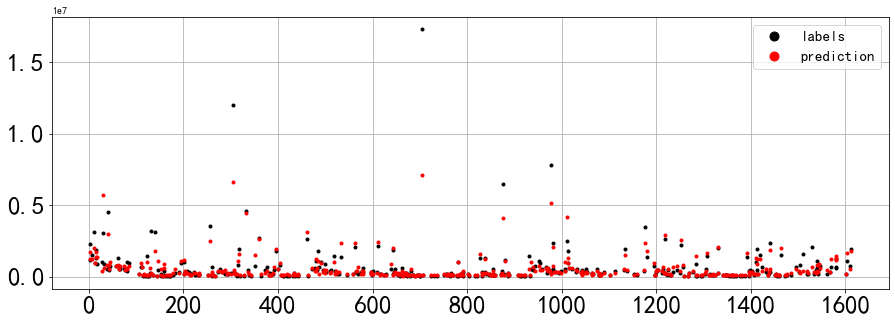

In [24]:
result['labels'].plot(style='k.',figsize=(15,5))
result['prediction'].plot(style='r.')
#设置图例文字大小和图示大小
plt.legend(fontsize=15,markerscale=3)
#设置坐标文字大小
plt.tick_params(labelsize=25)
#生成刻度线网格
plt.grid()

In [25]:
from sklearn import metrics
MSE = metrics.mean_squared_error(y_test,pred)
RMSE = np.sqrt(MSE)
print('(MSE,RMSE)=',(MSE,RMSE))

(MSE,RMSE)= (475086539934.499, 689265.2174123536)


In [26]:
print("模型评分: {:.2f}".format(gbm.score(X_test, y_test)))

模型评分: 0.72


In [27]:
from sklearn.metrics import r2_score, auc
r2_score(y_test,pred)

0.7216991759947253